### The AQIC and Fire Alarm projects are supported via NASA's Earth Science Technology Office (ESTO) from the Advanced Information Systems Technology (AIST) Program

# Fire Alarm: Science Data Platform for Wildfire and Air Quality API Demonstration

## Libraries, Functions and Inventories

The following libraries are needed to support accessing FireAlarm API. The functions called in this notebook are in the `firealarm_modules` folder.

### Libraries

In [1]:
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

import pandas as pd
from datetime import datetime, timedelta
import numpy as np
from IPython.display import Image
from owslib.wms import WebMapService
from urllib.request import urlopen
from PIL import Image as I
from PIL import ImageDraw, ImageFont

import firealarm_modules.plotting as plotting
import firealarm_modules.firealarm_processing as firealarm_processing

### Fire Alarm: Science Data Platform for Wildfire and Air Quality  DATA Inventory

The base url, https://ideas-digitaltwin.jpl.nasa.gov/nexus, is the entry to access FireAlarm API. In the following code snipet, it is used in conjunction with list endpoint to get a list of datasets.

In [2]:
BASE_URL = 'https://ideas-digitaltwin.jpl.nasa.gov'
NEXUS_URL = f'{BASE_URL}/nexus'
INSITU_URL = f'{BASE_URL}/insitu/1.0'

### Satellite and Model data inventory

In [15]:
aq_datasets = firealarm_processing.get_datasets()

In [16]:
pd.concat([aq_datasets[['GlobalAttrTitle', 'GlobalAttrSource']].head(), aq_datasets[['GlobalAttrTitle', 'GlobalAttrSource']].tail()])

,GlobalAttrTitle,GlobalAttrSource
0,MERRA-2 Global CDH,GES DISC
1,MERRA-2 Global PBLH,GES DISC
2,MERRA-2 Global TLML,GES DISC
3,MODIS Terra AOD 550 Dark Target Deep Blue Comb...,Giovanni
4,MODIS Terra Aerosol Optical Depth Land Ocean Mean,Giovanni
24,Sentinel-5P TROPOMI Methane CH4 California,GES DISC
25,Sentinel-5P TROPOMI Carbon Monoxide CO California,GES DISC
26,Sentinel-5P TROPOMI Tropospheric NO2 California,GES DISC
27,Sentinel-5P TROPOMI Total Ozone California,GES DISC
28,Sentinel-5P TROPOMI Sulphur Dioxide SO2 Califo...,GES DISC


### In-situ data inventory

In [17]:
insitu_collections = firealarm_processing.get_insitu_collections()
insitu_collections

,provider,project
0,AirNow,air_quality
1,AirNow,AQACF
2,GRIMM-Aethalometer,AQACF
3,PurpleAir,AQACF
4,QuantAQ,AQIC-Raw
5,QuantAQ,AQIC
6,QuantAQ,AQIC-Hourly
7,PurpleAir-GMU-Cal,air_quality
8,PurpleAir-GMU-Intermediate,air_quality
9,PurpleAir-GMU-Raw-Hourly,air_quality


In [18]:
airnow_sites = firealarm_processing.get_insitu_sites('air_quality', 'AirNow').drop_duplicates(['platform_short_name']).reset_index()
airnow_sites

,index,platform,platform_short_name,lat,lon,min_datetime,max_datetime
0,0,000010102,St. John's,47.652800,-52.816700,2018-01-01T00:00:00Z,2022-02-28T00:00:00Z
1,1,000010401,Mount Pearl,47.505000,-52.794700,2018-01-01T00:00:00Z,2022-02-28T00:00:00Z
2,2,000010501,Grand Falls Windsor,49.019400,-55.802800,2018-01-01T00:00:00Z,2021-03-31T00:00:00Z
3,3,000010601,Goose Bay,53.304700,-60.364400,2018-01-02T00:00:00Z,2024-03-31T00:00:00Z
4,4,000010602,MacPherson Avenue - Corner Brook,48.952240,-57.922070,2020-01-01T00:00:00Z,2022-02-28T00:00:00Z
...,...,...,...,...,...,...,...
3471,7059,TT1010003,Inchelium,48.296960,-118.202420,2018-01-09T00:00:00Z,2019-05-31T00:00:00Z
3472,7060,TT5420500,Santa Rosa Rancheria,36.233333,-119.765083,2018-01-01T00:00:00Z,2023-08-24T00:00:00Z
3473,7062,TT9209004,Miami,36.922222,-94.838890,2018-01-01T00:00:00Z,2024-03-31T00:00:00Z
3474,7064,UB1010001,Ulaanbaatar,47.928385,106.929470,2018-01-01T00:00:00Z,2024-03-31T00:00:00Z


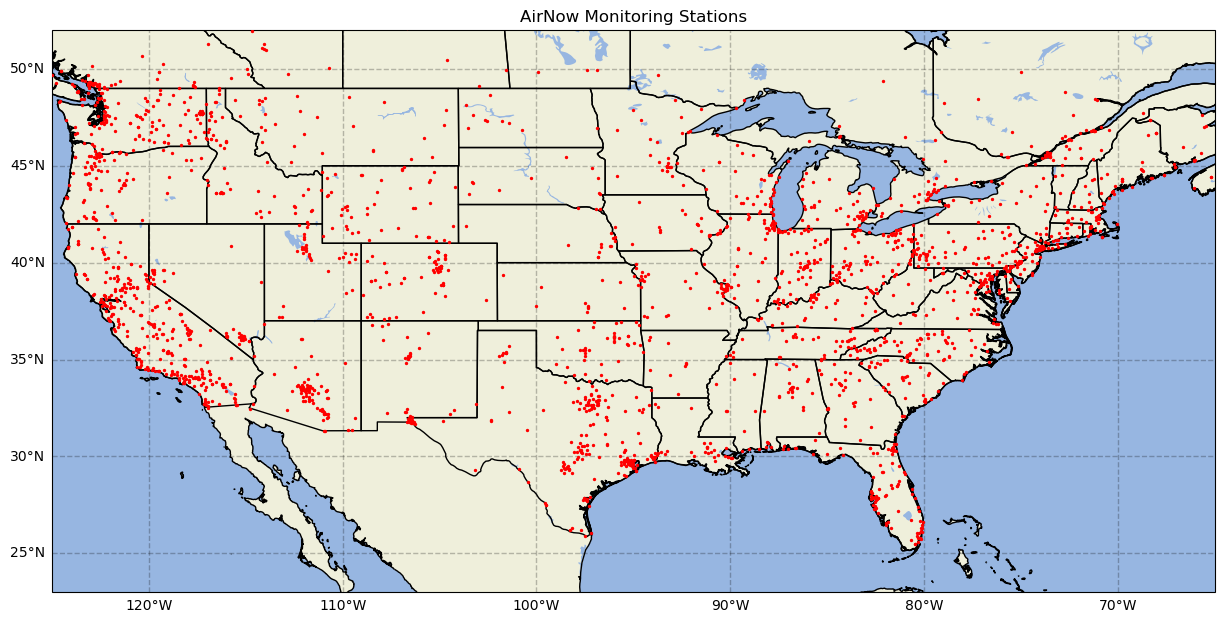

In [19]:
formatted_sites = [(s['lat'], s['lon'], s['platform_short_name']) for i,s in airnow_sites.iterrows()]
plotting.map_points(formatted_sites, region='usa', title='AirNow Monitoring Stations', legend=False, roads=False)

# 2025 Palisades and Eaton Fires Impacting Southern California

### Palisades and Eaton Fires MODIS Corrected Reflectance via GIBS

In [20]:
wms = WebMapService('https://gibs.earthdata.nasa.gov/wms/epsg4326/best/wms.cgi?', version='1.3.0')

layers = ['BlueMarble_NextGeneration',
          'MODIS_Aqua_CorrectedReflectance_TrueColor',
          'Reference_Features',
          'Reference_Labels']
font = ImageFont.truetype('Roboto-Bold.ttf', size=18)
color = 'rgb(255,255,255)'
frames = []

sdate = datetime(2025,1,7)
edate = datetime(2025,1,12)
dates = pd.date_range(sdate,edate-timedelta(days=1),freq='d')

print(f'Obtaining {len(dates)} days of imagery from GIBS...')

for day in dates[:10]:
    datatime = day.strftime("%Y-%m-%d")
    gibs_wms_url = 'https://gibs.earthdata.nasa.gov/wms/epsg4326/best/wms.cgi?'
    params = {
        'service': 'WMS',
        'version': '1.3.0',
        'request': 'GetMap',
        'layers': ','.join(layers),
        'styles': '',
        'srs': 'epsg:4326',  # Map projection
        'crs': 'epsg:4326',
        'bbox':','.join(['32','-121','36', '-115']),  # Bounds (min-lat, min-lon, max-lat, max-lon)
        'width': '500',
        'height': '500',
        'time':datatime,  # Time of data
        'format':'image/png',  # Image format
        'transparent':'TRUE',
        'exceptions': 'XML'
    }

    url = f'{gibs_wms_url}{"&".join([f"{k}={v}" for k,v in params.items()])}' 
    response = urlopen(url)
    image = I.open(response)
    draw = ImageDraw.Draw(image)
    draw.text((50, 12), f'MODIS Corrected Reflectance - {datatime}', fill='rgb(0,0,0)', font=font)
    frames.append(image)

Obtaining 5 days of imagery from GIBS...


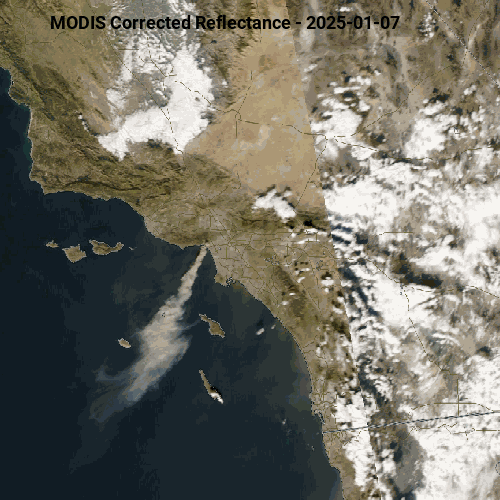

In [21]:
frames[0].save('MODIS.gif',
               format='GIF',
               append_images=frames,
               save_all=True,
               duration=1000,
               loop=0)

Image('MODIS.gif')

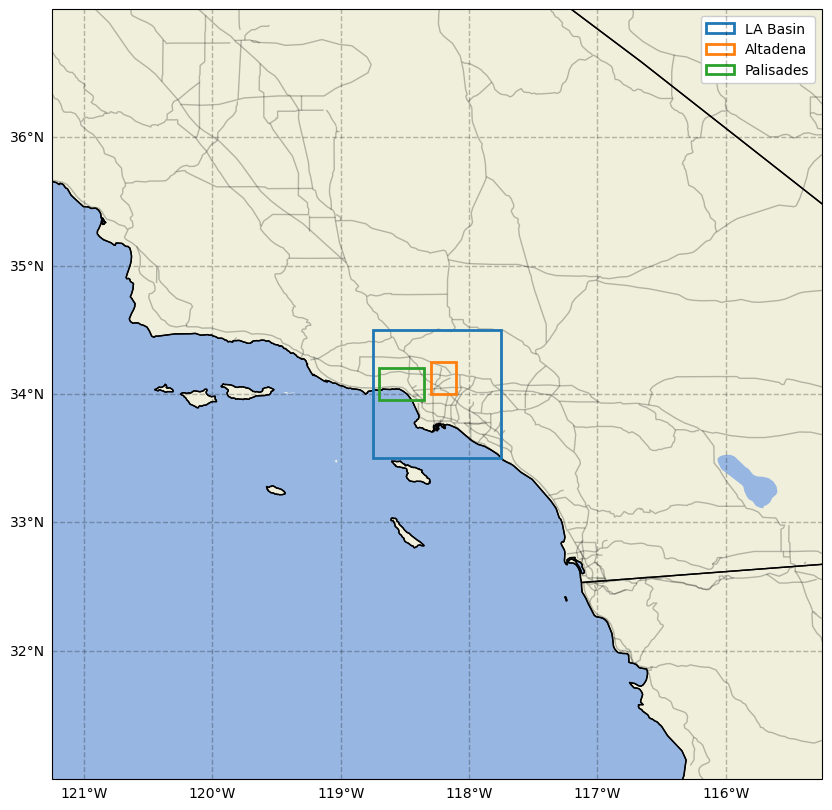

In [3]:
la_basin_fire_bb = {'min_lon': -118.75, 'max_lon': -117.75, 'min_lat': 33.5, 'max_lat': 34.5}
altadena_fire_bb = {'min_lon': -118.3, 'max_lon': -118.1, 'min_lat': 34, 'max_lat': 34.25}
palisades_fire_bb = {'min_lon': -118.7, 'max_lon': -118.35, 'min_lat': 33.95, 'max_lat': 34.2}
la_basin_fire_start = datetime(2025,1,1)
la_basin_fire_end = datetime(2025,1,15)

plotting.map_box([(la_basin_fire_bb, "LA Basin"), (altadena_fire_bb, "Altadena"), (palisades_fire_bb, "Palisades")], padding=2.5)

### TROPOMI CO LA Basin

In [23]:
tropomi_co_2025_la_fires_ts = firealarm_processing.spatial_timeseries('TROPOMI_CO_global', la_basin_fire_bb, la_basin_fire_start, la_basin_fire_end)
tropomi_co_eaton_altadena_ts = firealarm_processing.spatial_timeseries('TROPOMI_CO_global', altadena_fire_bb, la_basin_fire_start, la_basin_fire_end)
tropomi_co_eaton_palisades_ts = firealarm_processing.spatial_timeseries('TROPOMI_CO_global', palisades_fire_bb, la_basin_fire_start, la_basin_fire_end)

https://ideas-digitaltwin.jpl.nasa.gov/nexus/timeSeriesSpark?ds=TROPOMI_CO_global&minLon=-118.75&minLat=33.5&maxLon=-117.75&maxLat=34.5&startTime=2025-01-01T00%3A00%3A00Z&endTime=2025-01-15T00%3A00%3A00Z&lowPassFilter=False

Waiting for response from FireAlarm...took 11.226399666000361 seconds
https://ideas-digitaltwin.jpl.nasa.gov/nexus/timeSeriesSpark?ds=TROPOMI_CO_global&minLon=-118.3&minLat=34&maxLon=-118.1&maxLat=34.25&startTime=2025-01-01T00%3A00%3A00Z&endTime=2025-01-15T00%3A00%3A00Z&lowPassFilter=False

Waiting for response from FireAlarm...took 1.7348817079982837 seconds
https://ideas-digitaltwin.jpl.nasa.gov/nexus/timeSeriesSpark?ds=TROPOMI_CO_global&minLon=-118.7&minLat=33.95&maxLon=-118.35&maxLat=34.2&startTime=2025-01-01T00%3A00%3A00Z&endTime=2025-01-15T00%3A00%3A00Z&lowPassFilter=False

Waiting for response from FireAlarm...took 0.1754041669992148 seconds


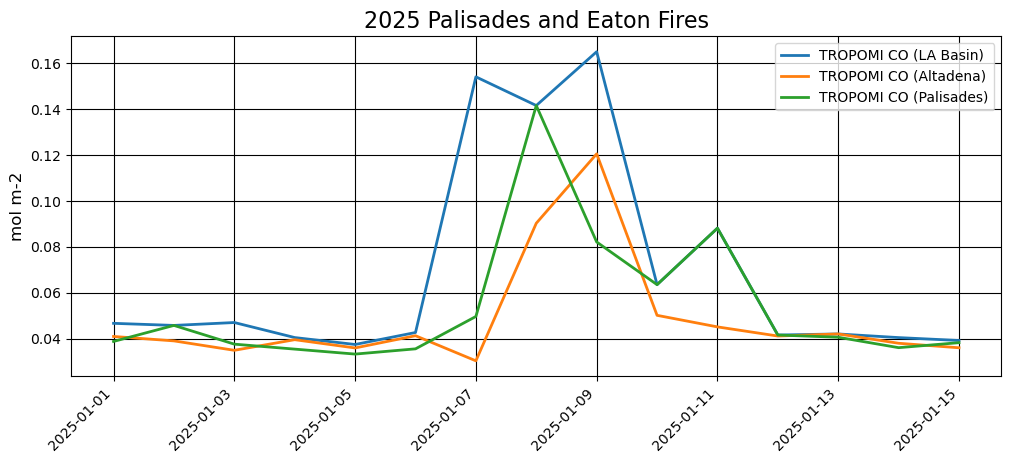

In [24]:
plotting.timeseries_plot([(tropomi_co_2025_la_fires_ts['maximum'], 'TROPOMI CO (LA Basin)'), 
                          (tropomi_co_eaton_altadena_ts['maximum'], 'TROPOMI CO (Altadena)'),
                          (tropomi_co_eaton_palisades_ts['maximum'], 'TROPOMI CO (Palisades)')],
                         '', 'mol m-2', '2025 Palisades and Eaton Fires', norm=False)


In [25]:
tropomi_co_la_2025_avg = firealarm_processing.temporal_mean('TROPOMI_CO_global', {'min_lon': -121, 'max_lon': -116, 'min_lat': 31, 'max_lat': 36}, datetime(2025,1,7), datetime(2025,1,9))

https://ideas-digitaltwin.jpl.nasa.gov/nexus/timeAvgMapSpark?ds=TROPOMI_CO_global&b=-121%2C31%2C-116%2C36&startTime=2025-01-07T00%3A00%3A00Z&endTime=2025-01-09T00%3A00%3A00Z

Waiting for response from FireAlarm... took 0.6986467919996358 seconds


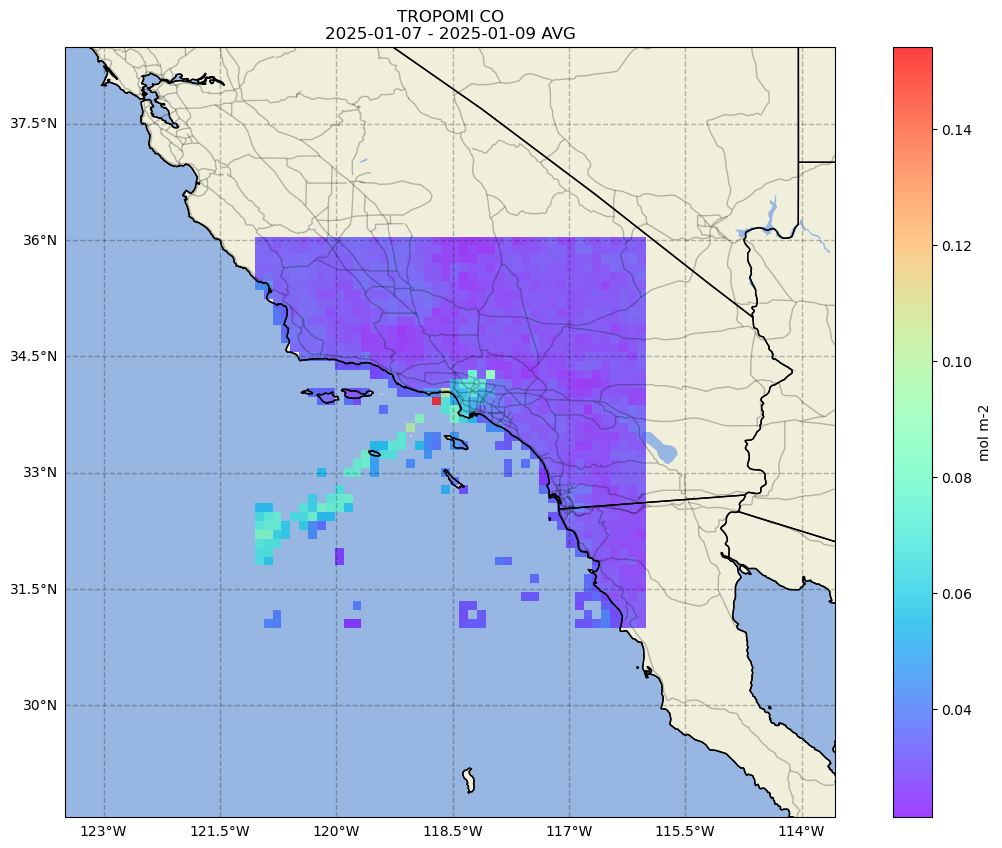

In [26]:
plotting.map_data(tropomi_co_la_2025_avg, f'TROPOMI CO\n2025-01-07 - 2025-01-09 AVG', cb_label='mol m-2')

In [27]:
tropomi_no2_2025_la_fires_ts = firealarm_processing.spatial_timeseries('TROPOMI_NO2_global', la_basin_fire_bb, la_basin_fire_start, la_basin_fire_end)
tropomi_no2_eaton_altadena_ts = firealarm_processing.spatial_timeseries('TROPOMI_NO2_global', altadena_fire_bb, la_basin_fire_start, la_basin_fire_end)
tropomi_no2_eaton_palisades_ts = firealarm_processing.spatial_timeseries('TROPOMI_NO2_global', palisades_fire_bb, la_basin_fire_start, la_basin_fire_end)

https://ideas-digitaltwin.jpl.nasa.gov/nexus/timeSeriesSpark?ds=TROPOMI_NO2_global&minLon=-118.75&minLat=33.5&maxLon=-117.75&maxLat=34.5&startTime=2025-01-01T00%3A00%3A00Z&endTime=2025-01-15T00%3A00%3A00Z&lowPassFilter=False

Waiting for response from FireAlarm...took 0.1802008750019013 seconds
https://ideas-digitaltwin.jpl.nasa.gov/nexus/timeSeriesSpark?ds=TROPOMI_NO2_global&minLon=-118.3&minLat=34&maxLon=-118.1&maxLat=34.25&startTime=2025-01-01T00%3A00%3A00Z&endTime=2025-01-15T00%3A00%3A00Z&lowPassFilter=False

Waiting for response from FireAlarm...took 0.18899174999751267 seconds
https://ideas-digitaltwin.jpl.nasa.gov/nexus/timeSeriesSpark?ds=TROPOMI_NO2_global&minLon=-118.7&minLat=33.95&maxLon=-118.35&maxLat=34.2&startTime=2025-01-01T00%3A00%3A00Z&endTime=2025-01-15T00%3A00%3A00Z&lowPassFilter=False

Waiting for response from FireAlarm...took 0.17923370800053817 seconds


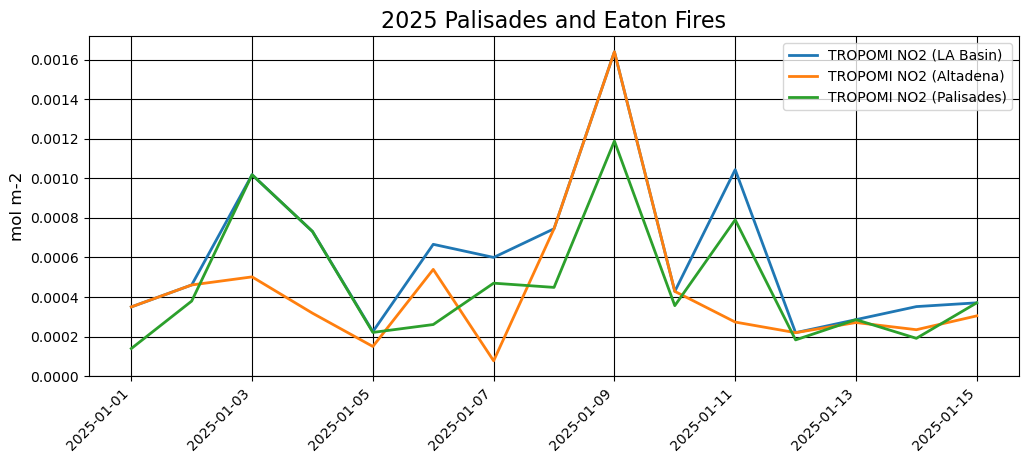

In [28]:
plotting.timeseries_plot([(tropomi_no2_2025_la_fires_ts['maximum'], 'TROPOMI NO2 (LA Basin)'), 
                          (tropomi_no2_eaton_altadena_ts['maximum'], 'TROPOMI NO2 (Altadena)'),
                          (tropomi_no2_eaton_palisades_ts['maximum'], 'TROPOMI NO2 (Palisades)')],
                         '', 'mol m-2', '2025 Palisades and Eaton Fires', norm=False)


In [29]:
tropomi_no2_la_2025_avg = firealarm_processing.temporal_mean('TROPOMI_NO2_global', {'min_lon': -121, 'max_lon': -116, 'min_lat': 31, 'max_lat': 36}, datetime(2025,1,7), datetime(2025,1,9))

https://ideas-digitaltwin.jpl.nasa.gov/nexus/timeAvgMapSpark?ds=TROPOMI_NO2_global&b=-121%2C31%2C-116%2C36&startTime=2025-01-07T00%3A00%3A00Z&endTime=2025-01-09T00%3A00%3A00Z

Waiting for response from FireAlarm... took 0.4683761249980307 seconds


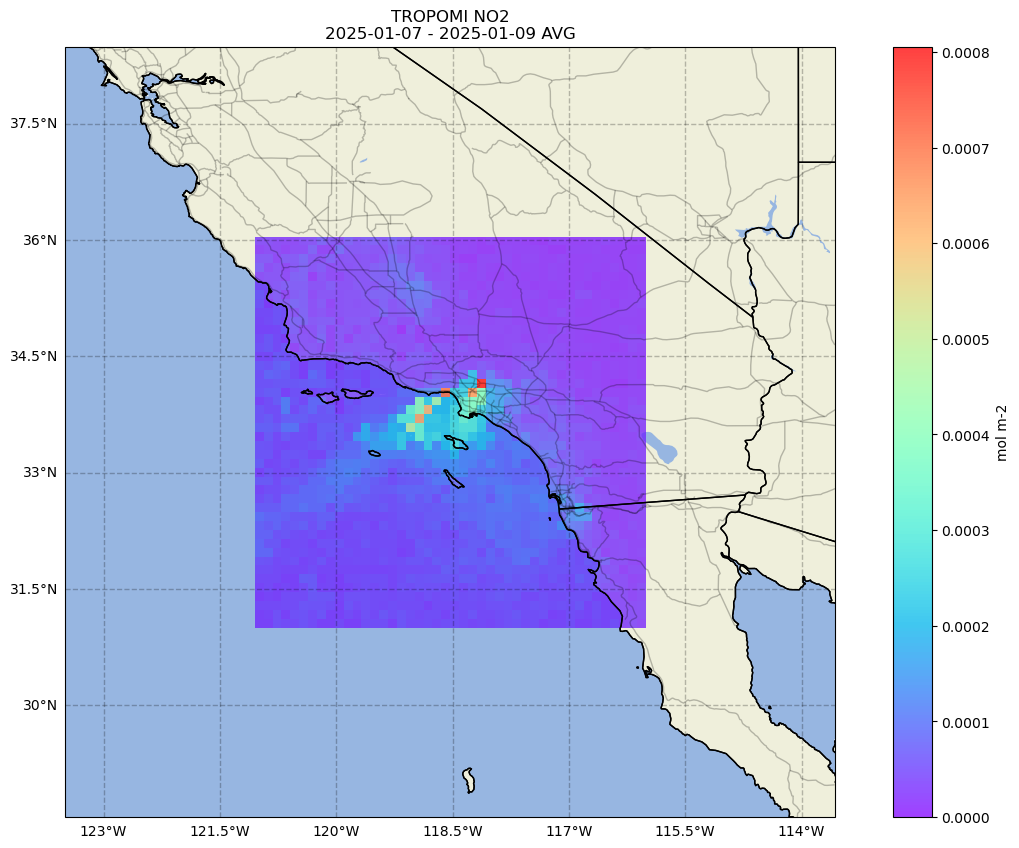

In [30]:
plotting.map_data(tropomi_no2_la_2025_avg, f'TROPOMI NO2\n2025-01-07 - 2025-01-09 AVG', cb_label="mol m-2")


### VIIRS Aerosol Optical Thickness

In [31]:
viirs_la_2025_daily_diff = firealarm_processing.daily_diff('laads-1degx1deg-daily-global_Aerosol_Optical_Thickness_550_Land_Ocean_Mean', 'laads-1degx1deg-daily-global_Aerosol_Optical_Thickness_550_Land_Ocean_Mean_clim', la_basin_fire_bb, la_basin_fire_start, la_basin_fire_end)

https://ideas-digitaltwin.jpl.nasa.gov/nexus/dailydifferenceaverage_spark?dataset=laads-1degx1deg-daily-global_Aerosol_Optical_Thickness_550_Land_Ocean_Mean&climatology=laads-1degx1deg-daily-global_Aerosol_Optical_Thickness_550_Land_Ocean_Mean_clim&b=-118.75%2C33.5%2C-117.75%2C34.5&startTime=2025-01-01T00%3A00%3A00Z&endTime=2025-01-15T00%3A00%3A00Z

Waiting for response from FireAlarm... took 1.4847342499997467 seconds


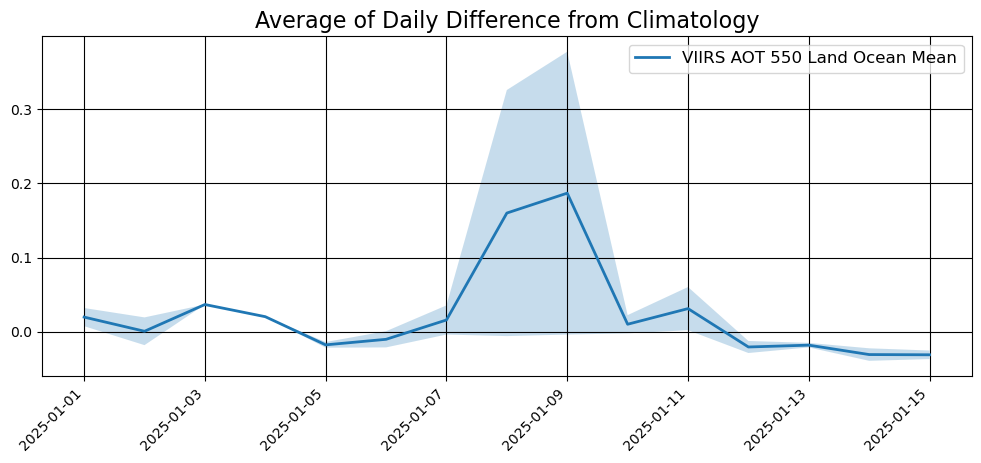

In [32]:
plotting.timeseries_bands_plot(viirs_la_2025_daily_diff, 'VIIRS AOT 550 Land Ocean Mean', '', '', f'Average of Daily Difference from Climatology')

### TEMPO - NO2, Ozone, Formaldehyde

In [4]:
tempo_no2_ts = firealarm_processing.spatial_timeseries('TEMPO_NO2_L3_V03', la_basin_fire_bb, la_basin_fire_start, la_basin_fire_end)
tempo_o3_ts = firealarm_processing.spatial_timeseries('TEMPO_O3TOT_L3_V03', altadena_fire_bb, la_basin_fire_start, la_basin_fire_end)
tempo_hcho_ts = firealarm_processing.spatial_timeseries('TEMPO_HCHO_L3_V03', palisades_fire_bb, la_basin_fire_start, la_basin_fire_end)

https://ideas-digitaltwin.jpl.nasa.gov/nexus/timeSeriesSpark?ds=TEMPO_NO2_L3_V03&minLon=-118.75&minLat=33.5&maxLon=-117.75&maxLat=34.5&startTime=2025-01-01T00%3A00%3A00Z&endTime=2025-01-15T00%3A00%3A00Z&lowPassFilter=False

Waiting for response from FireAlarm...took 11.362864458999866 seconds
https://ideas-digitaltwin.jpl.nasa.gov/nexus/timeSeriesSpark?ds=TEMPO_O3TOT_L3_V03&minLon=-118.3&minLat=34&maxLon=-118.1&maxLat=34.25&startTime=2025-01-01T00%3A00%3A00Z&endTime=2025-01-15T00%3A00%3A00Z&lowPassFilter=False

Waiting for response from FireAlarm...took 0.4071312500000204 seconds
https://ideas-digitaltwin.jpl.nasa.gov/nexus/timeSeriesSpark?ds=TEMPO_HCHO_L3_V03&minLon=-118.7&minLat=33.95&maxLon=-118.35&maxLat=34.2&startTime=2025-01-01T00%3A00%3A00Z&endTime=2025-01-15T00%3A00%3A00Z&lowPassFilter=False

Waiting for response from FireAlarm...took 0.33770924999998897 seconds


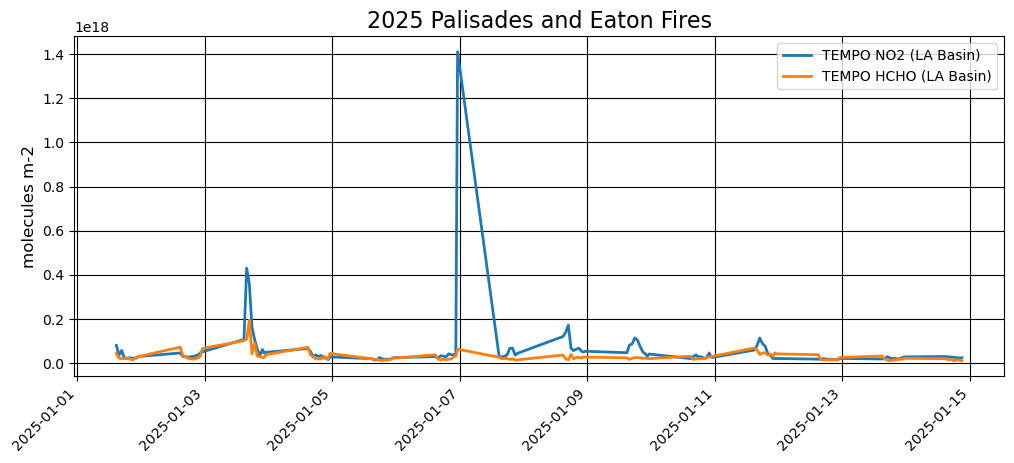

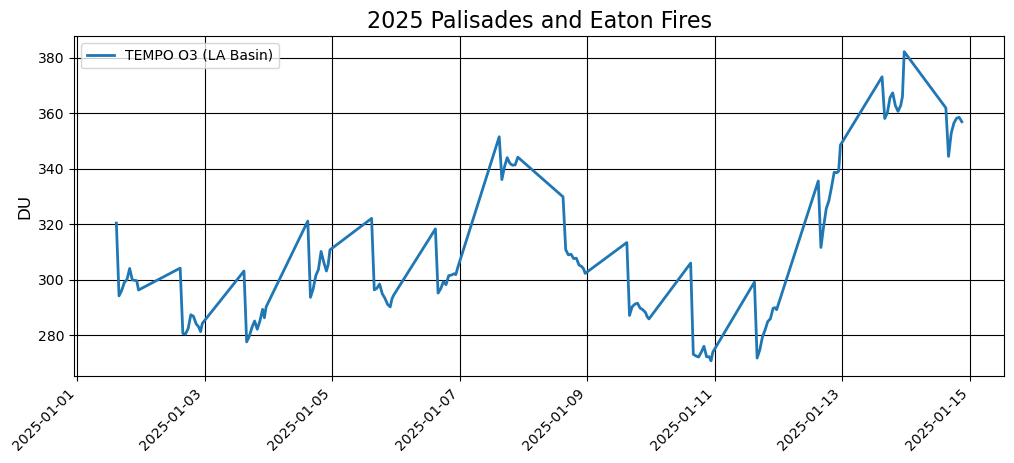

In [6]:
plotting.timeseries_plot([(tempo_no2_ts['maximum'], 'TEMPO NO2 (LA Basin)'), 
                          (tempo_hcho_ts['maximum'], 'TEMPO HCHO (LA Basin)')],
                         '', 'molecules m-2', '2025 Palisades and Eaton Fires', norm=False)
plotting.timeseries_plot([(tempo_o3_ts['maximum'], 'TEMPO O3 (LA Basin)')],
                         '', 'DU', '2025 Palisades and Eaton Fires', norm=False)


In [10]:
tempo_no2_la_2025_avg = firealarm_processing.temporal_mean('TEMPO_NO2_L3_V03', {'min_lon': -121, 'max_lon': -116, 'min_lat': 31, 'max_lat': 35}, datetime(2025,1,7), datetime(2025,1,9))
tempo_o3_la_2025_avg = firealarm_processing.temporal_mean('TEMPO_O3TOT_L3_V03', {'min_lon': -121, 'max_lon': -116, 'min_lat': 31, 'max_lat': 35}, datetime(2025,1,7), datetime(2025,1,9))
tempo_hcho_la_2025_avg = firealarm_processing.temporal_mean('TEMPO_HCHO_L3_V03', {'min_lon': -121, 'max_lon': -116, 'min_lat': 31, 'max_lat': 35}, datetime(2025,1,7), datetime(2025,1,9))

https://ideas-digitaltwin.jpl.nasa.gov/nexus/timeAvgMapSpark?ds=TEMPO_NO2_L3_V03&b=-121%2C31%2C-116%2C35&startTime=2025-01-07T00%3A00%3A00Z&endTime=2025-01-09T00%3A00%3A00Z

Waiting for response from FireAlarm... took 10.24624704200005 seconds
https://ideas-digitaltwin.jpl.nasa.gov/nexus/timeAvgMapSpark?ds=TEMPO_O3TOT_L3_V03&b=-121%2C31%2C-116%2C35&startTime=2025-01-07T00%3A00%3A00Z&endTime=2025-01-09T00%3A00%3A00Z

Waiting for response from FireAlarm... took 1.7093521249998958 seconds
https://ideas-digitaltwin.jpl.nasa.gov/nexus/timeAvgMapSpark?ds=TEMPO_HCHO_L3_V03&b=-121%2C31%2C-116%2C35&startTime=2025-01-07T00%3A00%3A00Z&endTime=2025-01-09T00%3A00%3A00Z

Waiting for response from FireAlarm... took 1.6228835830002026 seconds


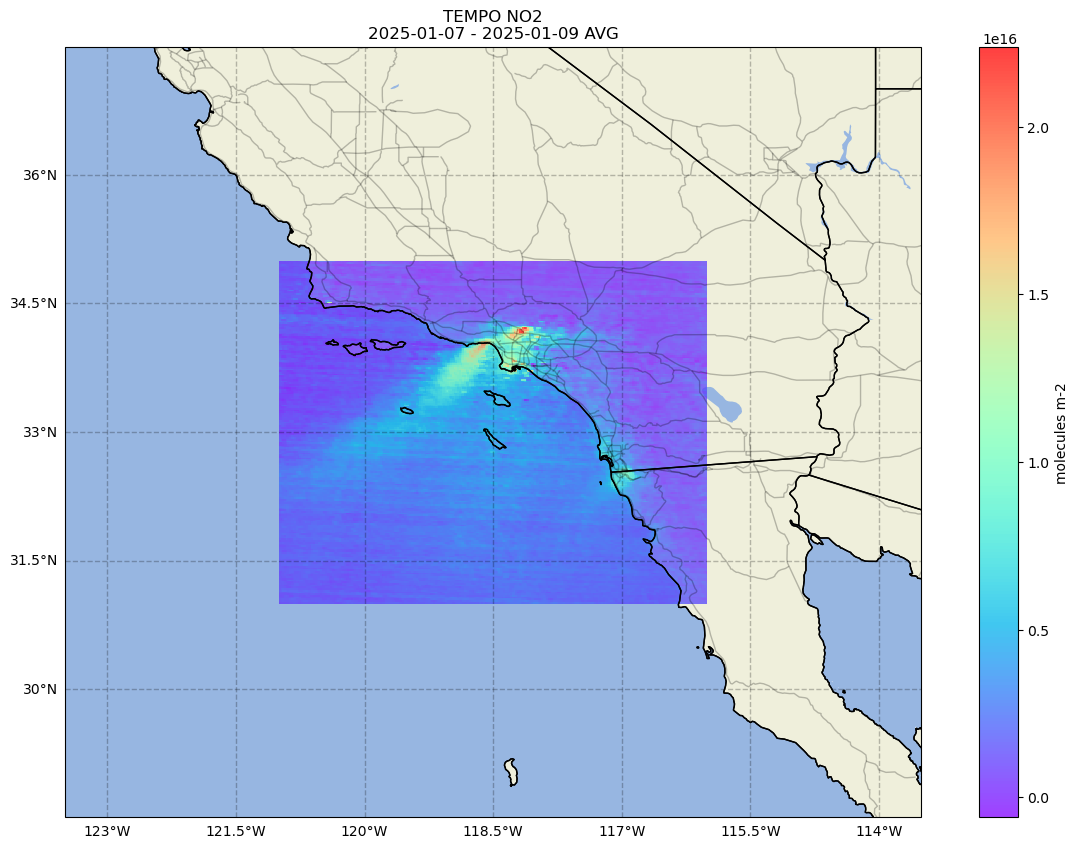

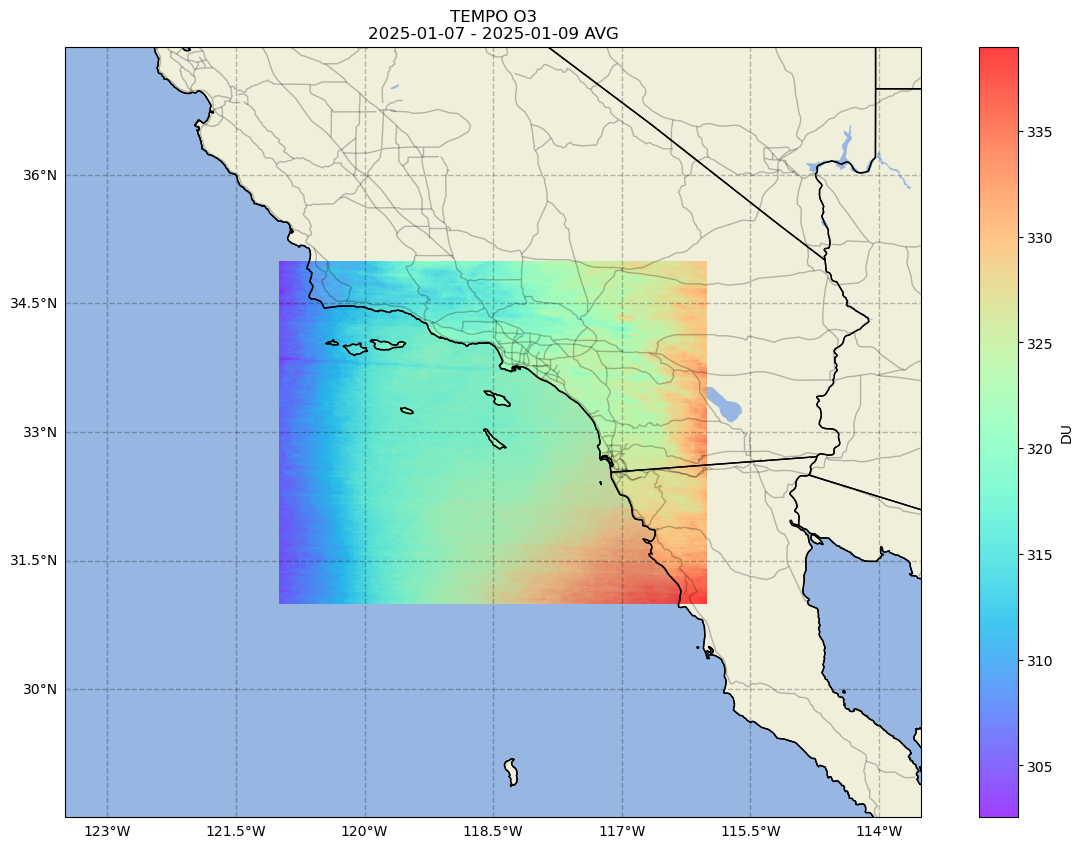

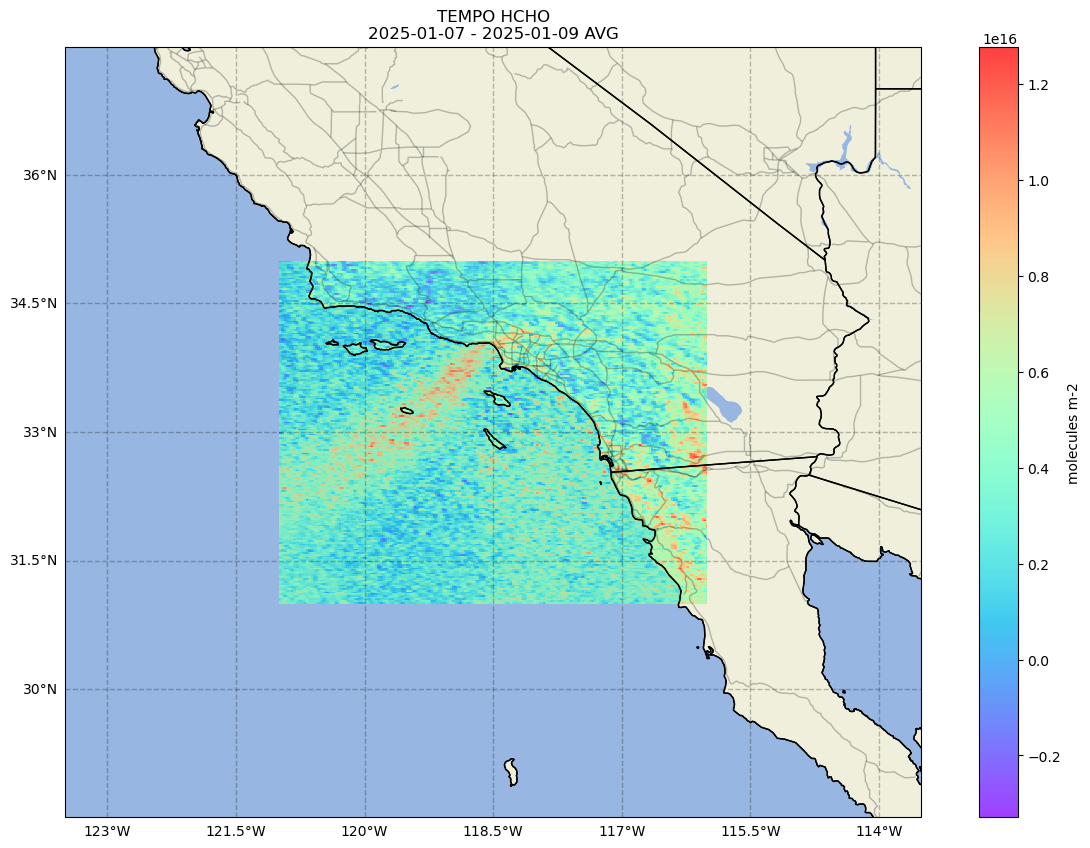

In [11]:
plotting.map_data(tempo_no2_la_2025_avg, f'TEMPO NO2\n2025-01-07 - 2025-01-09 AVG', cb_label='molecules m-2')
plotting.map_data(tempo_o3_la_2025_avg, f'TEMPO O3\n2025-01-07 - 2025-01-09 AVG', cb_label='DU')
plotting.map_data(tempo_hcho_la_2025_avg, f'TEMPO HCHO\n2025-01-07 - 2025-01-09 AVG', cb_label='molecules m-2')